Initial estimated parameters:
[ 0.44835505  0.46948963  0.10933107 -0.465099  ]
Final estimated parameters:
[ 0.33948797  0.4007968   0.01627847 -0.34694588]
True parameters:
[ 0.314216  0.35833   0.053851 -0.333695]


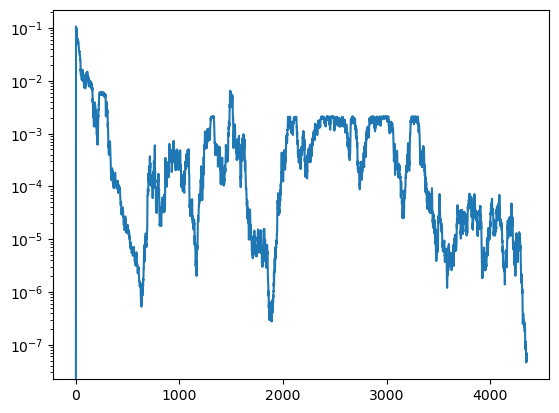

In [1]:
from qdots_qll.models import game
from qdots_qll.run import Run
import qdots_qll.all_funcs as all_f
from qdots_qll.smc import run_smc_loop, _iteration_smc
from jax import vmap
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt


seed = 10
key = jax.random.PRNGKey(seed=seed)

key, subkey = jax.random.split(key)


model = game.physical_model()

true_pars = game.true_pars
bnds = jnp.array(
    [
        [0.01, 0.9],
        [0.01, 0.9],
        [0.001, 0.22],
        [-0.01, -0.9],
    ]
)


number_of_particles = 1000

max_iterations = 10000
min_iterations = 100


init_weights = all_f.initialize_weights(number_of_particles)
init_particles_locations = all_f.initialize_particle_locations(
    subkey, model.number_of_parameters, number_of_particles, bnds
)
initial_cov_array = jnp.zeros(
    [max_iterations, model.number_of_parameters, model.number_of_parameters]
)

initial_estimates_array = jnp.zeros(
    [max_iterations, model.number_of_parameters]
)

initial_run = Run(
    iteration=0,
    key=key,
    weights=init_weights,
    particles_locations=init_particles_locations,
    cov_array=initial_cov_array,
    estimates_array=initial_estimates_array,
    max_iterations=max_iterations,
    min_iterations=min_iterations,
    std_threshold=1e-7,
)

print("Initial estimated parameters:")
print(all_f.est_mean(initial_run.particles_locations, initial_run.weights))

result = run_smc_loop(
    initial_run=initial_run,
    func_update_smc=_iteration_smc,
    model=model,
    true_pars=true_pars,
)

print("Final estimated parameters:")
print(all_f.est_mean(result.particles_locations, result.weights))
print("True parameters:")
print(true_pars)


plt.plot(vmap(jnp.linalg.norm, 0)(result.cov_array)[0 : result.iteration])
plt.yscale("log")
plt.show()


differences_squared = ((true_pars - result.estimates_array)**2)[0 : result.iteration]

mse_array = jnp.mean(differences_squared, axis=1)

In [6]:
differences_squared = ((true_pars - result.estimates_array)**2)[0 : result.iteration]

mse_array = jnp.mean(differences_squared, axis=1)

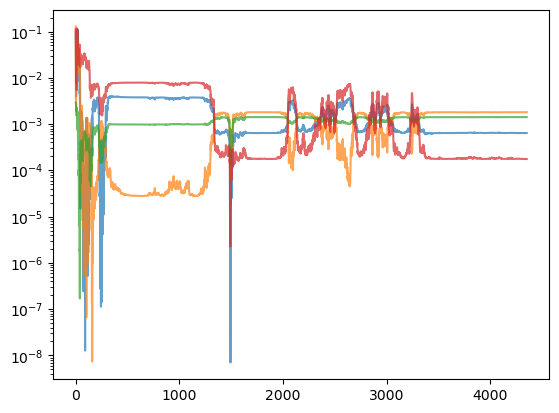

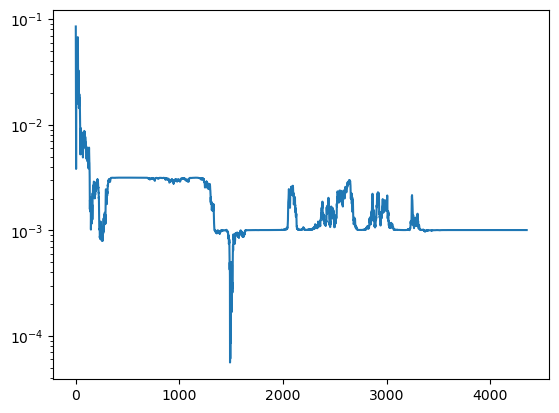

In [7]:
for i in range(differences_squared.shape[1]):
    plt.plot(differences_squared[:, i], alpha=0.7)

plt.yscale('log')
# plt.xscale('log')
plt.show()


plt.plot(mse_array)
plt.yscale('log')

plt.show()